# Idea: use xgboost to predict, among the sessions that have numeric  reference before clickout, when the clickout coincides with the last reference

In [1]:
import data

In [2]:
import pandas as pd

In [3]:
import numpy as np

In [4]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [5]:
import xgboost as xgb

In [6]:
import matplotlib.pyplot as plt

In [7]:
from utils.check_folder import check_folder

In [8]:
import pickle

In [9]:
from tqdm.auto import tqdm  # for notebooks
tqdm.pandas()

## Build the dataset

In [10]:
def existsIndex(df, idx):
    try:
        df.loc[idx]
        return True
    except KeyError:
        return False

In [11]:
def RepresentsInt(s):
    try: 
        int(s)
        return True
    except TypeError:
        return False
    except ValueError:
        return False

In [17]:
df = data.train_df('full').head(100000)

In [13]:
df

,user_id,session_id,timestamp,step,action_type,reference,platform,city,device,current_filters,impressions,prices
0,00RL8Z82B2Z1,aff3928535f48,1541037460,1,search for poi,Newtown,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
1,00RL8Z82B2Z1,aff3928535f48,1541037522,2,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
2,00RL8Z82B2Z1,aff3928535f48,1541037522,3,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
3,00RL8Z82B2Z1,aff3928535f48,1541037532,4,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
4,00RL8Z82B2Z1,aff3928535f48,1541037532,5,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
5,00RL8Z82B2Z1,aff3928535f48,1541037532,6,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
6,00RL8Z82B2Z1,aff3928535f48,1541037532,7,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
7,00RL8Z82B2Z1,aff3928535f48,1541037532,8,interaction item image,666856,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
8,00RL8Z82B2Z1,aff3928535f48,1541037542,9,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN
9,00RL8Z82B2Z1,aff3928535f48,1541037542,10,interaction item image,109038,AU,"Sydney, Australia",mobile,NaN,NaN,NaN


In [48]:
def func(x):
    y = x[x['action_type'] == 'clickout item']
    if len(y) > 0:
        clk = y.tail(1)
        head_index = x.head(1).index
        
        # considering only the past!
        x = x.loc[head_index.values[0]:clk.index.values[0]-1]
        
        impr = clk['impressions'].values[0].split('|')
        references = x['reference'].values
        
        # features
        features = {'times_impression_appeared': [],
                    'time_elapsed_from_last_time_impression_appeared': [], 'steps_from_last_time_impression_appeared': [],
                    'kind_action_reference_appeared': [], 'impression_position': [], 'label': []}
        count = 0
        for i in impr:
            indices = np.where(references == str(i))[0]

            features['impression_position'].append(count+1)
            if len(indices) > 0:
                row_reference = x.head(indices[-1]+1).tail(1)
                features['steps_from_last_time_impression_appeared'].append(len(x)-indices[-1])
                features['time_elapsed_from_last_time_impression_appeared'].append(int(clk['timestamp'].values[0] - row_reference['timestamp'].values[0]))
                features['kind_action_reference_appeared'].append(row_reference['action_type'].values[0])
            else:
                features['steps_from_last_time_impression_appeared'].append(0)
                features['time_elapsed_from_last_time_impression_appeared'].append(np.inf)
                features['kind_action_reference_appeared'].append('no_action')
    
            if clk['reference'].values[0] == i:
                features['label'].append(1)
                features['times_impression_appeared'].append(len(indices)-1)
            else:
                features['label'].append(0)
                features['times_impression_appeared'].append(len(indices))
            
            count += 1
            
        return pd.DataFrame(features)


In [49]:
dataset = df.groupby(['user_id', 'session_id']).progress_apply(func)
one_hot = pd.get_dummies(dataset['kind_action_reference_appeared'])
dataset = dataset.drop(['kind_action_reference_appeared'],axis = 1)
#dataset = dataset.join(one_hot)

In [50]:
dataset = dataset.join(one_hot)
# del df

In [51]:
dataset

times_impression_appeared  \
user_id      session_id                                    
0004IOZI7CKF 0146f7cb014ba 0                           0   
                           1                           0   
                           2                          -1   
                           3                           0   
                           4                           0   
                           5                           0   
                           6                           0   
                           7                           0   
                           8                           0   
                           9                           0   
                           10                          0   
                           11                          0   
                           12                          0   
                           13                          0   
                           14                          0   
                           15                          0   
                           16                          0   
                           17                          0   
                           18                          0   
                           19                          0   
                           20                          0   
                           21                          0   
                           22                          0   
                           23                          0   
                           24                          0   
004STL2FQU99 24ab1f448fa9c 0                           0   
                           1                           0   
                           2                           0   
                           3                           0   
                           4                           0   
...                                                  ...   
ZZRDO4E49IX8 95b67d0f9cc2e 18                         -1   
                           19                          0   
                           20                          0   
                           21                          0   
                           22                          0   
ZZWHEYWBUNJB 04690b2bf9697 0                          -1   
                           1                           0   
                           2                           0   
                           3                           0   
                           4                           0   
                           5                           0   
                           6                           0   
                           7                           0   
                           8                           0   
                           9                           0   
                           10                          0   
                           11                          0   
                           12                          0   
                           13                          0   
                           14                          0   
                           15                          0   
                           16                          0   
                           17                          0   
                           18                          0   
                           19                          0   
                           20                          0   
                           21                          0   
                           22                          0   
                           23                          0   
                           24                          0   

                               time_elapsed_from_last_time_impression_appeared  \
user_id      session_id                                                          
0004IOZI7CKF 0146f7cb014ba 0                                               inf   
    

In [52]:
X, y = dataset.iloc[:, [1,2,3,5,6,7,8,9,10,11]],dataset.iloc[:,4]

In [53]:
X

time_elapsed_from_last_time_impression_appeared  \
user_id      session_id                                                          
0004IOZI7CKF 0146f7cb014ba 0                                               inf   
                           1                                               inf   
                           2                                               inf   
                           3                                               inf   
                           4                                               inf   
                           5                                               inf   
                           6                                               inf   
                           7                                               inf   
                           8                                               inf   
                           9                                               inf   
                           10                                              inf   
                           11                                              inf   
                           12                                              inf   
                           13                                              inf   
                           14                                              inf   
                           15                                              inf   
                           16                                              inf   
                           17                                              inf   
                           18                                              inf   
                           19                                              inf   
                           20                                              inf   
                           21                                              inf   
                           22                                              inf   
                           23                                              inf   
                           24                                              inf   
004STL2FQU99 24ab1f448fa9c 0                                               inf   
                           1                                               inf   
                           2                                               inf   
                           3                                               inf   
                           4                                               inf   
...                                                                        ...   
ZZRDO4E49IX8 95b67d0f9cc2e 18                                              inf   
                           19                                              inf   
                           20                                              inf   
                           21                                              inf   
                           22                                              inf   
ZZWHEYWBUNJB 04690b2bf9697 0                                               inf   
                           1                                               inf   
                           2                                               inf   
                           3                                               inf   
                           4                                               inf   
                           5                                               inf   
                           6                                               inf   
                           7                                               inf   
                           8                                               inf   
                           9                                               inf   
                           10                                              inf   
             

## Split the data

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### More or less balanced ;)

In [55]:
sum(y_test.values)/len(y_test)

0.04411959545996555

## Train on it

In [56]:
xg_reg = xgb.XGBClassifier(objective ='binary:logistic')#, colsample_bytree = 0.3, learning_rate = 0.1,
                #max_depth = 5, alpha = 10, n_estimators = 10)

In [57]:
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_test)

### Feature importance

([<matplotlib.axis.XTick at 0x7fc26d37e2b0>,
 <a list of 10 Text xticklabel objects>)

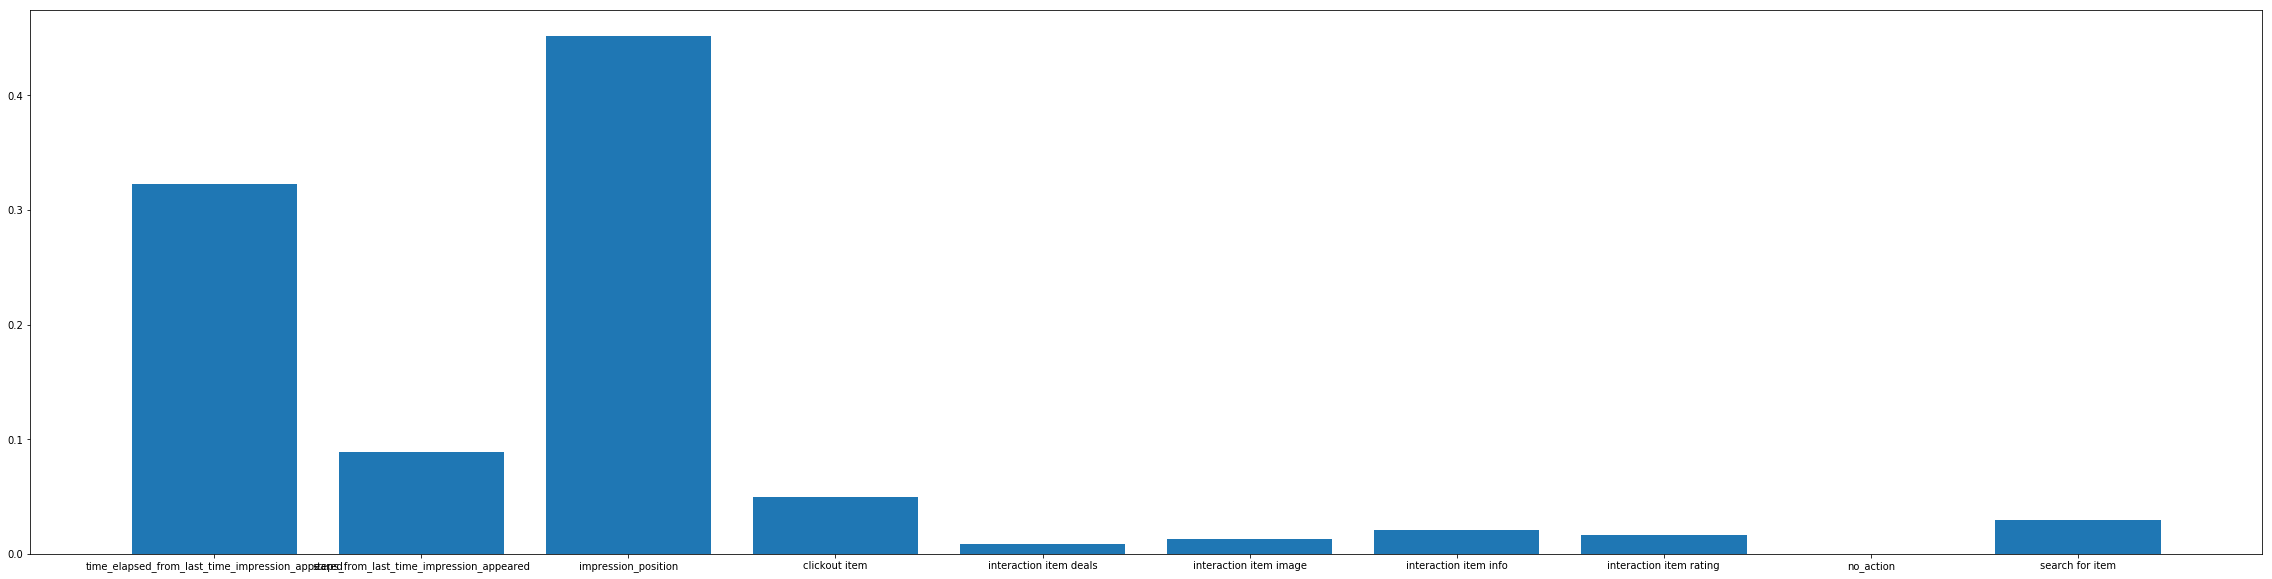

In [58]:
x = np.arange(len(X_train.columns.values))
fig, ax = plt.subplots(figsize=(40, 10))
plt.bar(x, height = xg_reg.feature_importances_) 
plt.xticks(x, X_train.columns.values)

## Training results

In [59]:
target_names = ['clk_diff_ref', 'clk_eq_ref']
print(classification_report(y_test, preds, target_names=target_names))

              precision    recall  f1-score   support

clk_diff_ref       0.97      1.00      0.98     21644
  clk_eq_ref       0.83      0.28      0.42       999

   micro avg       0.97      0.97      0.97     22643
   macro avg       0.90      0.64      0.70     22643
weighted avg       0.96      0.97      0.96     22643



In [60]:
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 96.57%
